In [1]:
%matplotlib inline
import sys
sys.path.append("../lib/")
import os
import string
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.tree import plot_tree
import seaborn as sns
import graphviz
import shap

from raman_lib.visualization import (plot_spectra_peaks, 
                                     plot_qc_summary, 
                                     plot_confidence_scores, 
                                     plot_coefs, 
                                     plot_confusion_matrix, 
                                     plot_roc_curve, 
                                     plot_validation_curve,
                                     plot_roc_comparison,
                                     boxplot_comparison)

# Setup

In [2]:
dataset = "pro" # L_540_2022_C_E_R

In [3]:
results_path = Path("../results/") / dataset
img_path = Path("../img/") / dataset

img_path.mkdir(parents=True, exist_ok=True)

In [4]:
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))

y, y_key = pd.factorize(data.label)

In [5]:
rocs = {}
aucs = {}
p_vals = {}
accs = {}
f1_scores = {}
fit_times = {}
predict_times = {}

In [6]:
plt.style.use("seaborn-paper")
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["figure.dpi"] = 200

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10

# Quality Control

In [7]:
qc_results = pd.read_csv(results_path / (dataset + "_qc_scores.csv"))

qc_results.describe()

,Median Height,N Peaks
count,359.000000,359.000000
mean,1102.687995,7.353760
std,658.422275,4.421277
min,0.000000,0.000000
25%,614.755359,3.000000
50%,812.686753,7.000000
75%,1470.516201,11.500000
max,2922.066544,15.000000


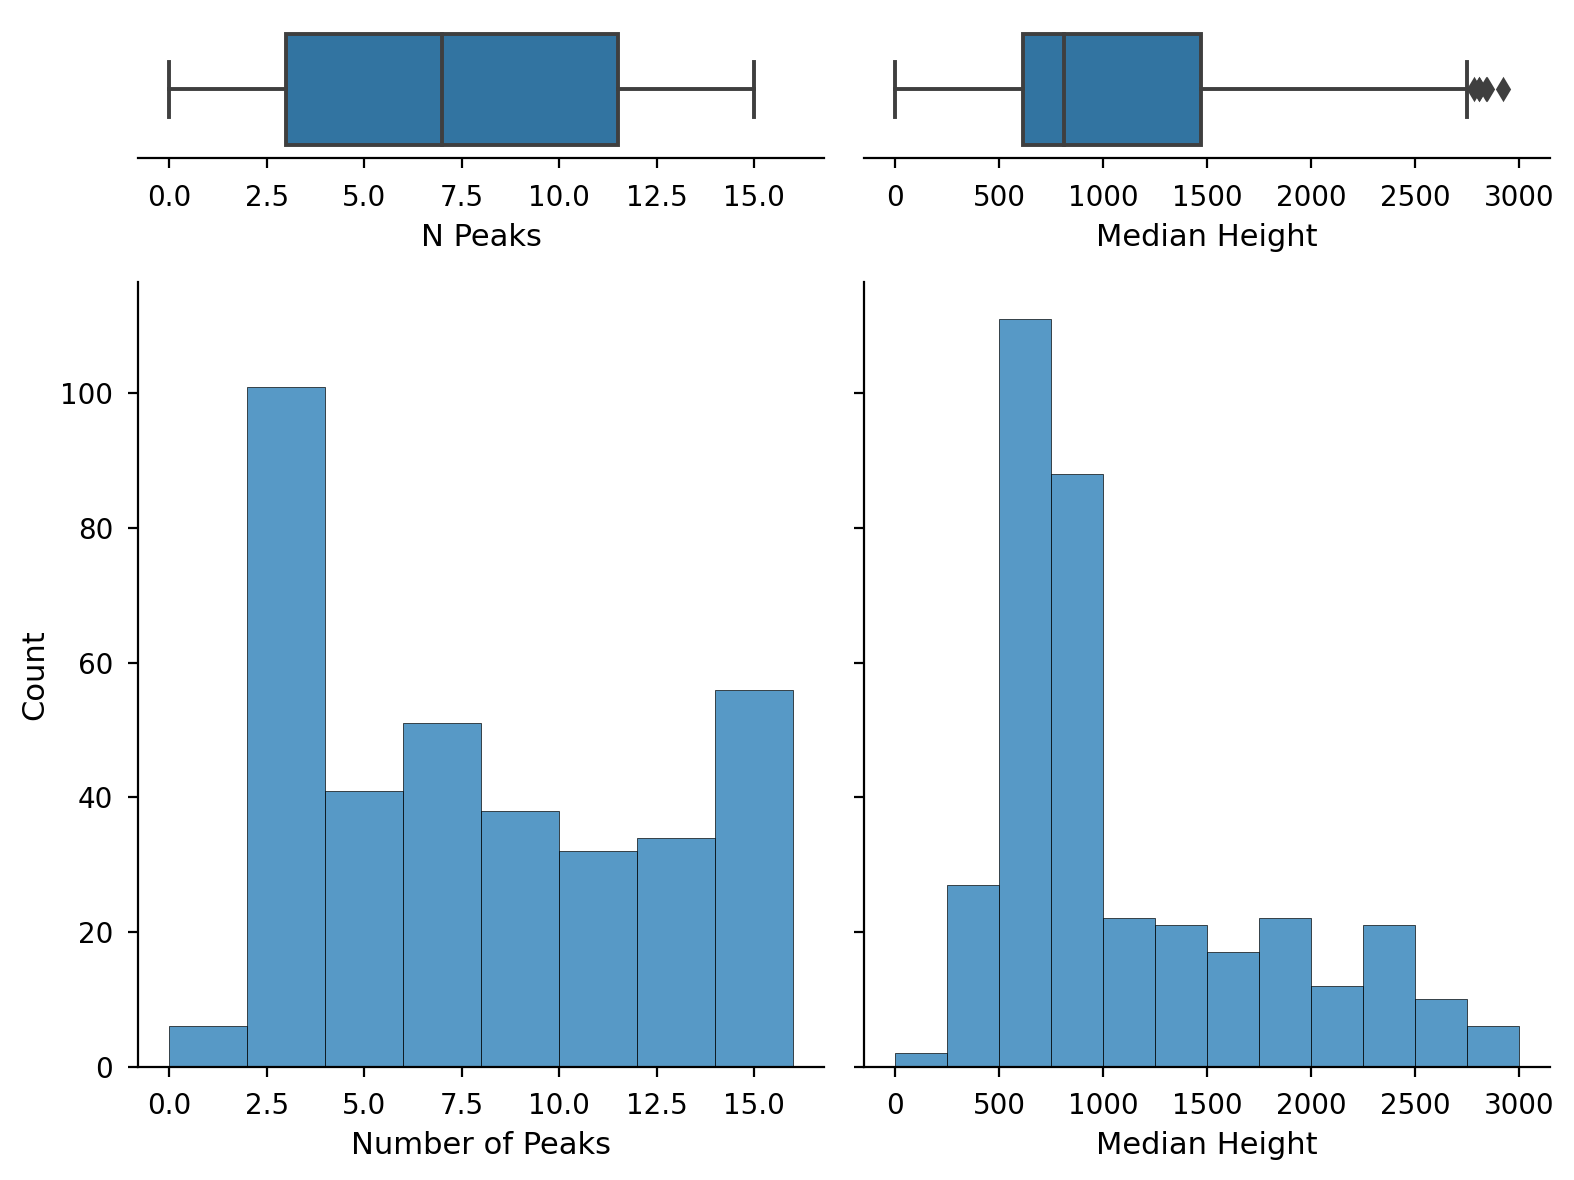

In [8]:
fig, ((ax_box1, ax_box2), (ax_hist1, ax_hist2)) = plt.subplots(
    2, 2, sharex="col", sharey="row", gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=qc_results.iloc[:,1], ax=ax_box1)
sns.boxplot(x=qc_results.iloc[:,0], ax=ax_box2)
sns.histplot(qc_results.iloc[:,1], ax=ax_hist1, binrange=None, binwidth=2)
sns.histplot(qc_results.iloc[:,0], ax=ax_hist2, binrange=None, binwidth=250)

ax_box1.set(yticks=[])
ax_box2.set(yticks=[])
sns.despine(ax=ax_hist1)
sns.despine(ax=ax_hist2)
sns.despine(ax=ax_box1, left=True)
sns.despine(ax=ax_box2, left=True)

ax_hist1.set_xlabel("Number of Peaks")
ax_hist2.set_xlabel(qc_results.columns[0])

#ax_hist1.set_ylim([None, ymax_peaks])
#ax_hist2.set_ylim([None, ymax_score])

ax_box1.tick_params(axis="x", labelbottom=True)
ax_box2.tick_params(axis="x", labelbottom=True)

fig.tight_layout()

# Dimensionality Reduction
## LDA
### Overview

In [9]:
current_path = results_path / "lda_dim_reduction/lda/"
name = "LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

AttributeError: 'DataFrame' object has no attribute 'test_f1'

### Confidence scores by class

Text(0, 0.5, 'Confidence score (-)')

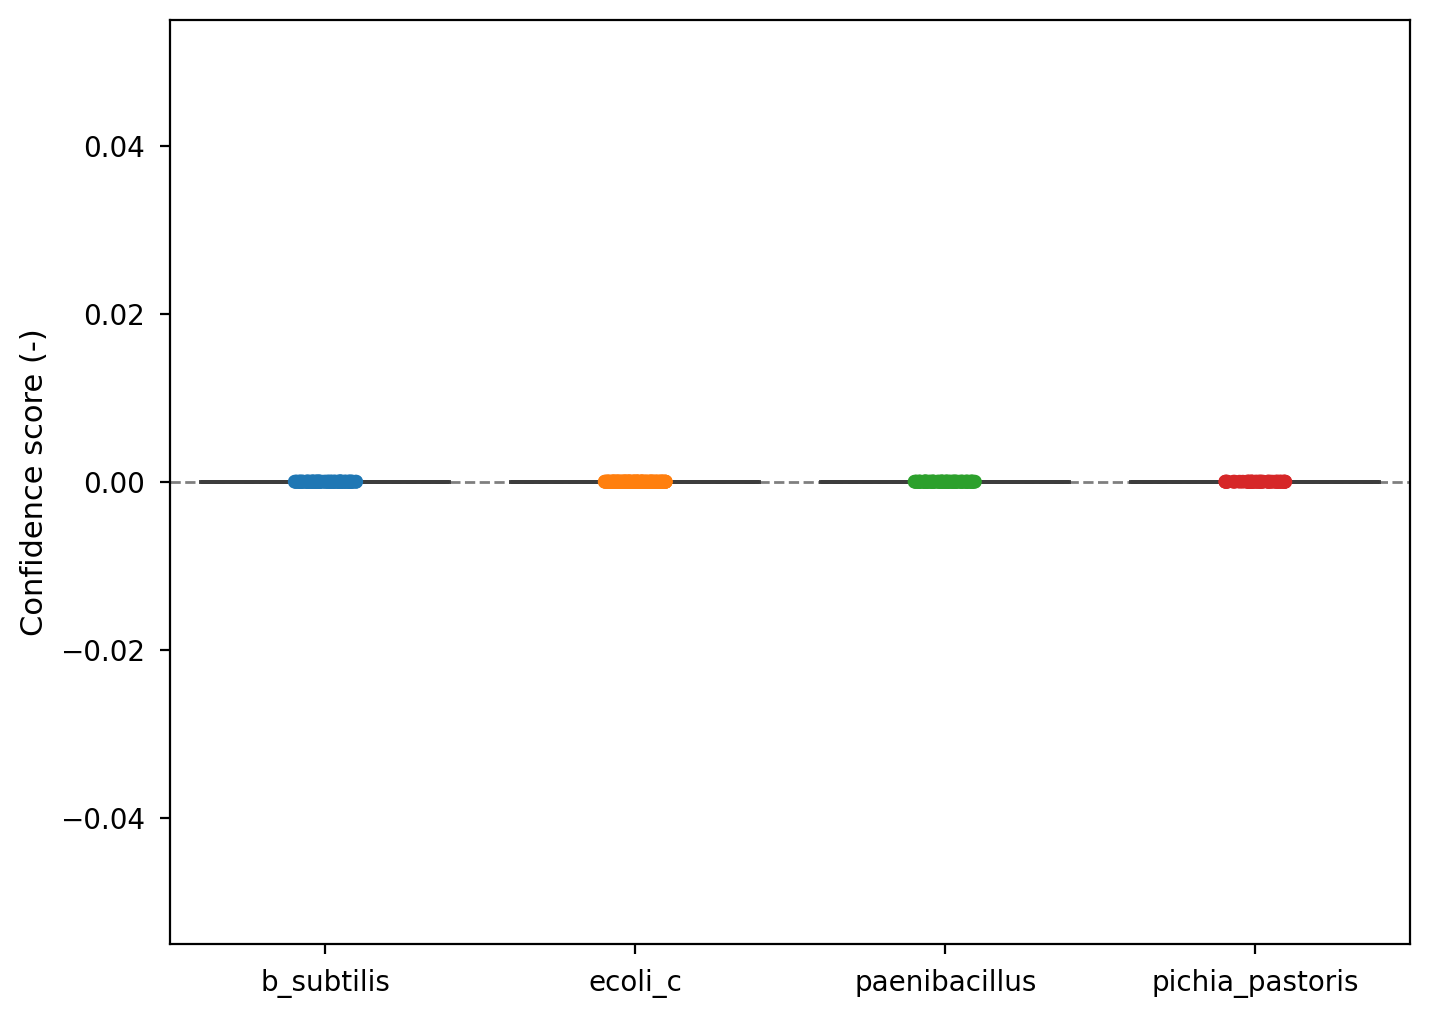

In [10]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.5)
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.set_ylabel("Confidence score (-)")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

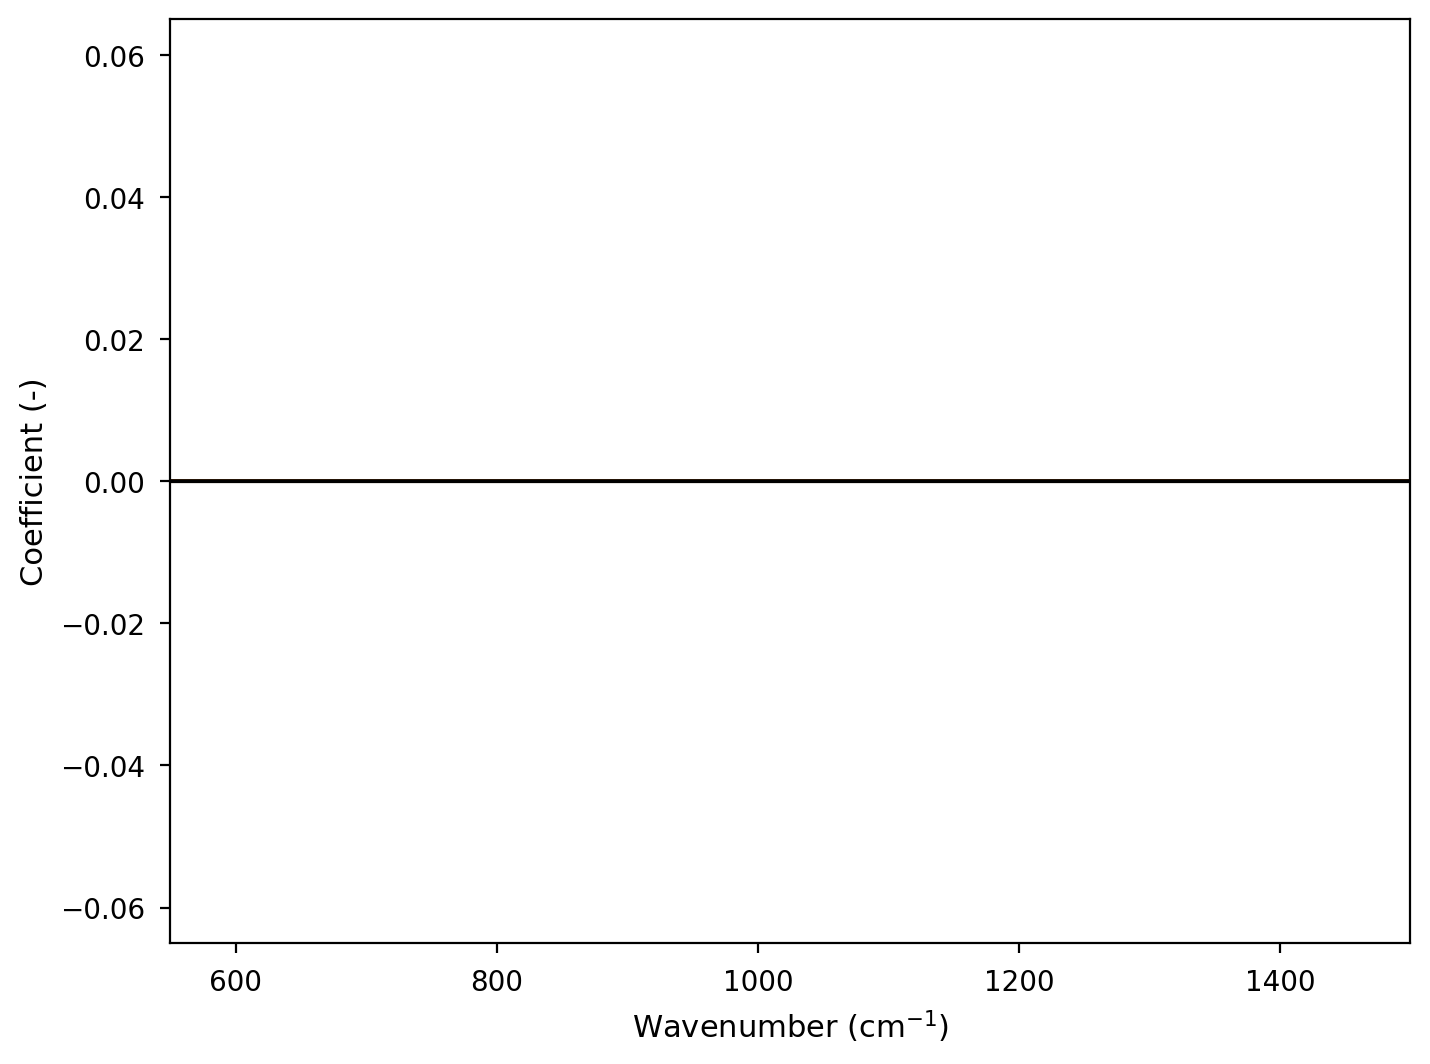

In [11]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax)

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)

### Confusion Matrix

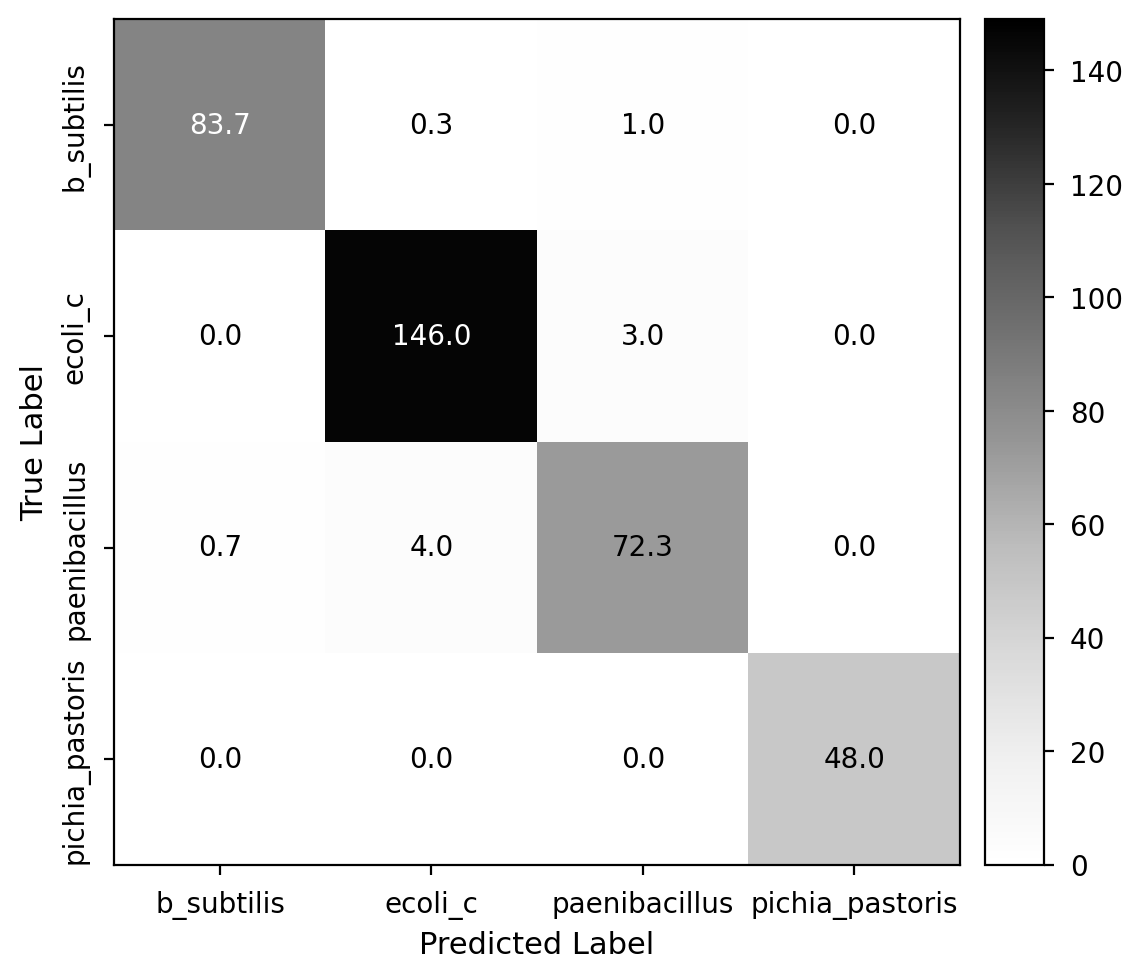

In [12]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

NameError: name 'roc_auc_curve' is not defined

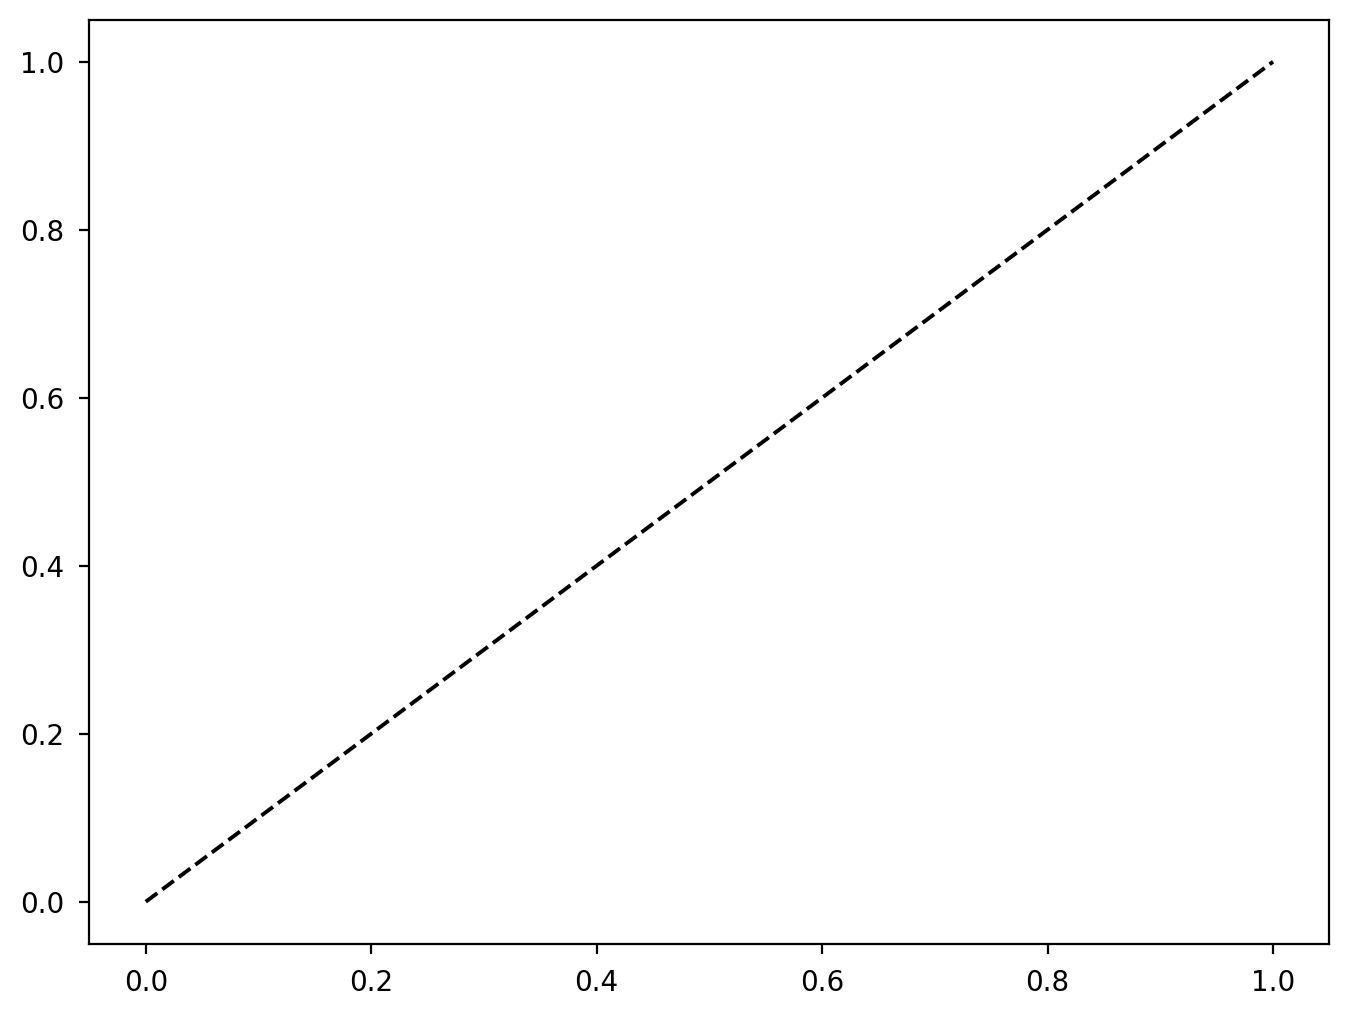

In [13]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")

rocs[name] = roc
aucs[name] = auc

## PCA-LDA
### Overview

In [14]:
current_path = results_path / "lda_dim_reduction/pca_lda/"
name = "PCA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

AttributeError: 'DataFrame' object has no attribute 'test_f1'

### Validation Curve

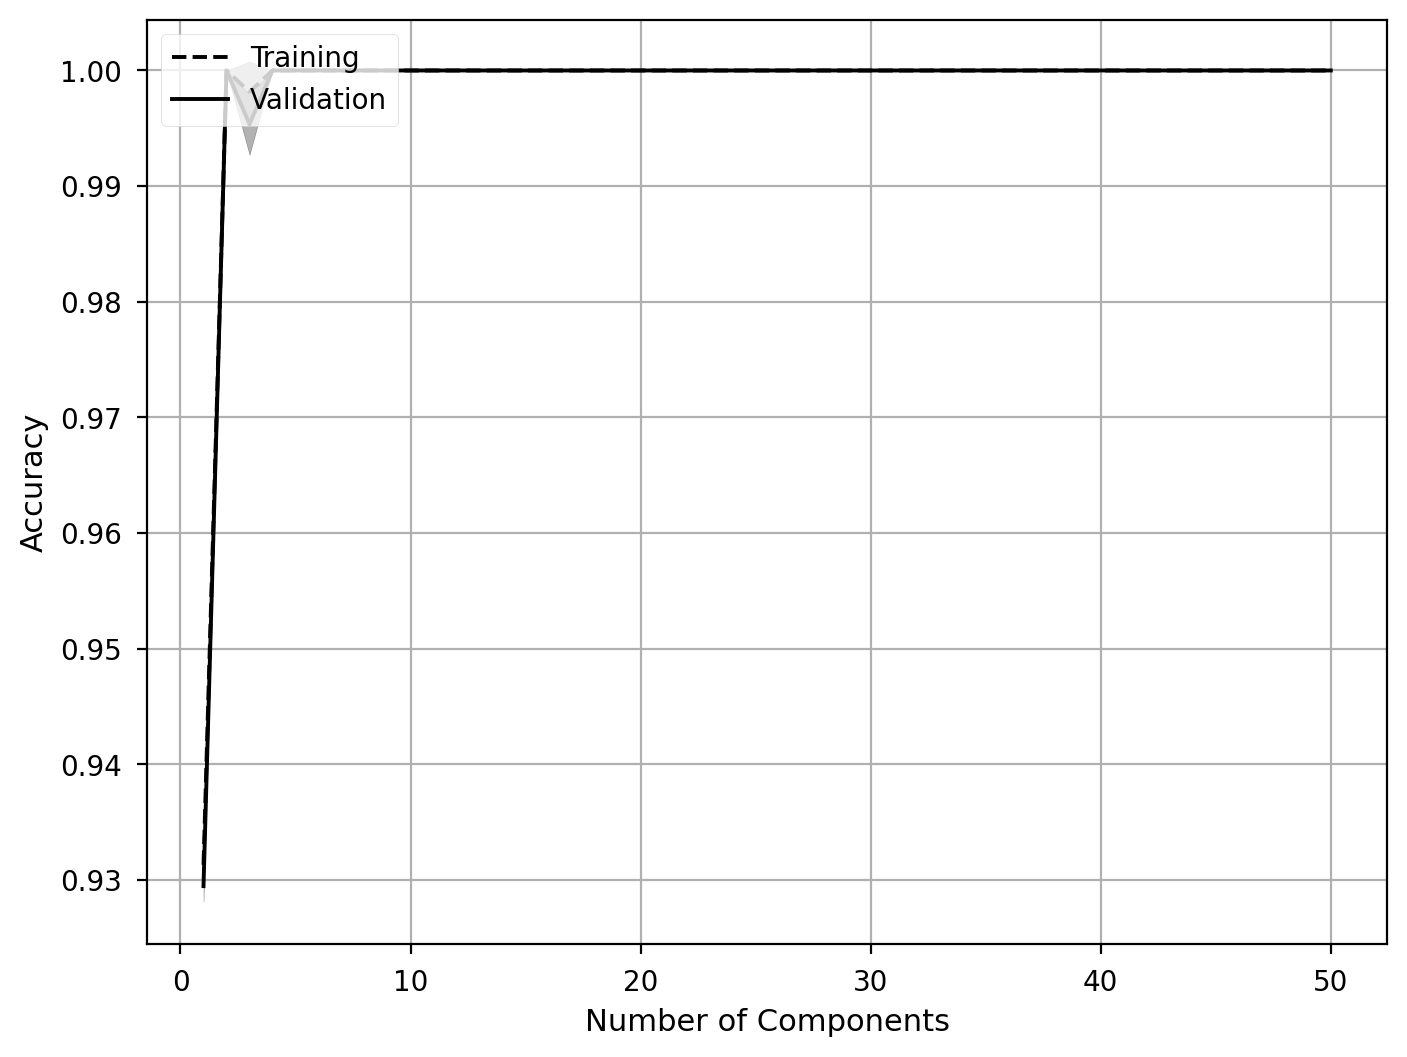

In [15]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Number of Components")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

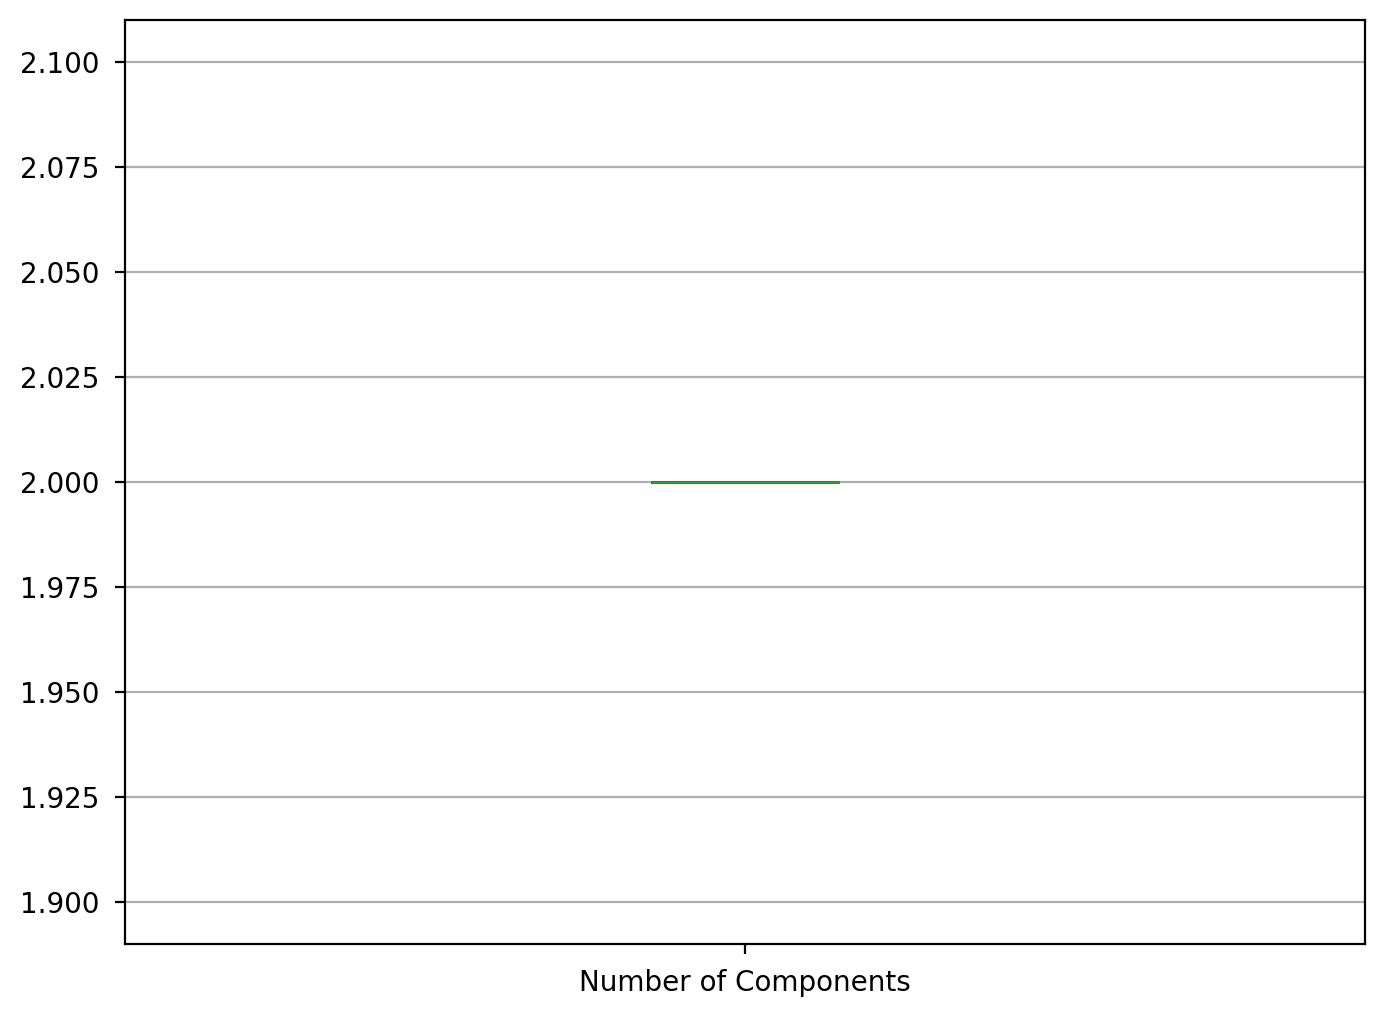

In [16]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["Number of Components"])
ax.grid(axis="y")

### Confidence scores by class

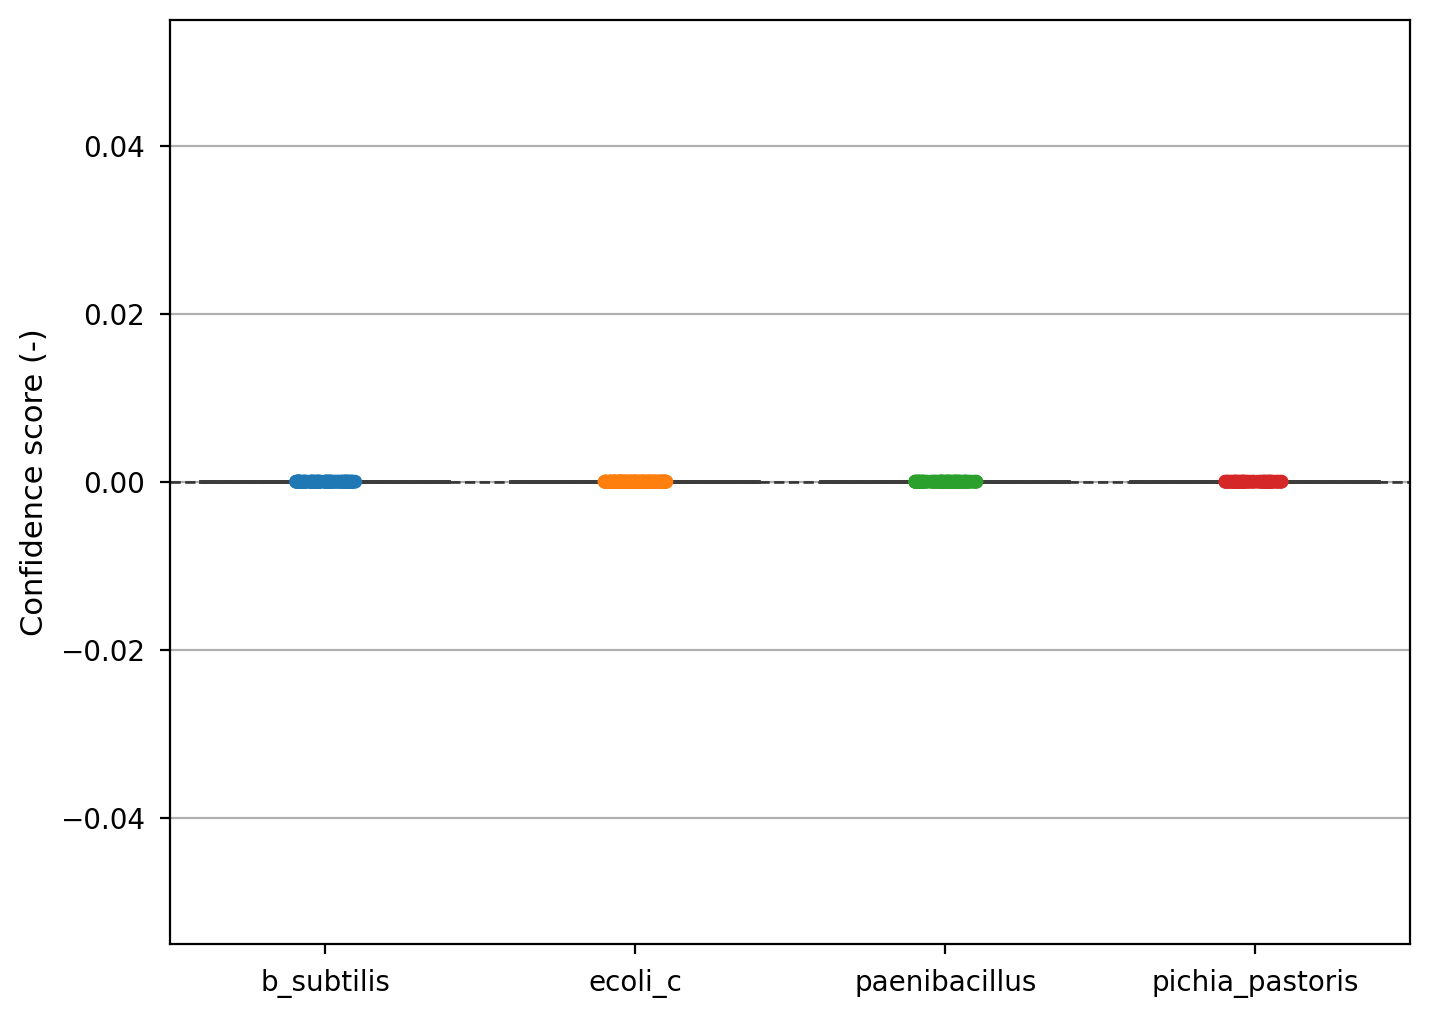

In [17]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

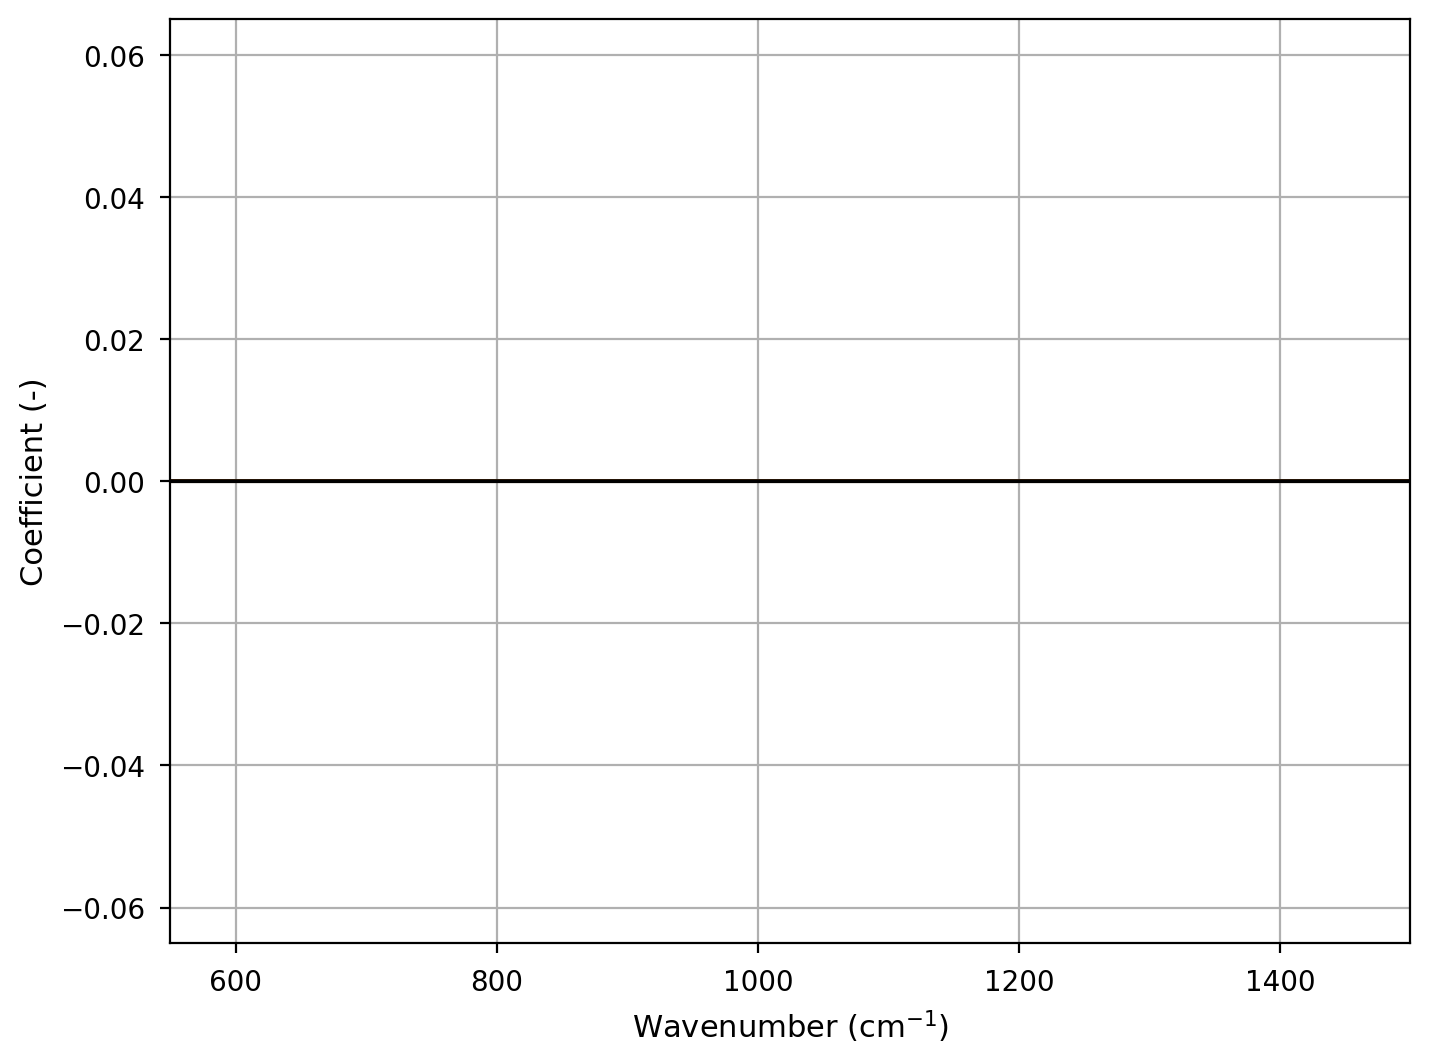

In [18]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 0.1, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

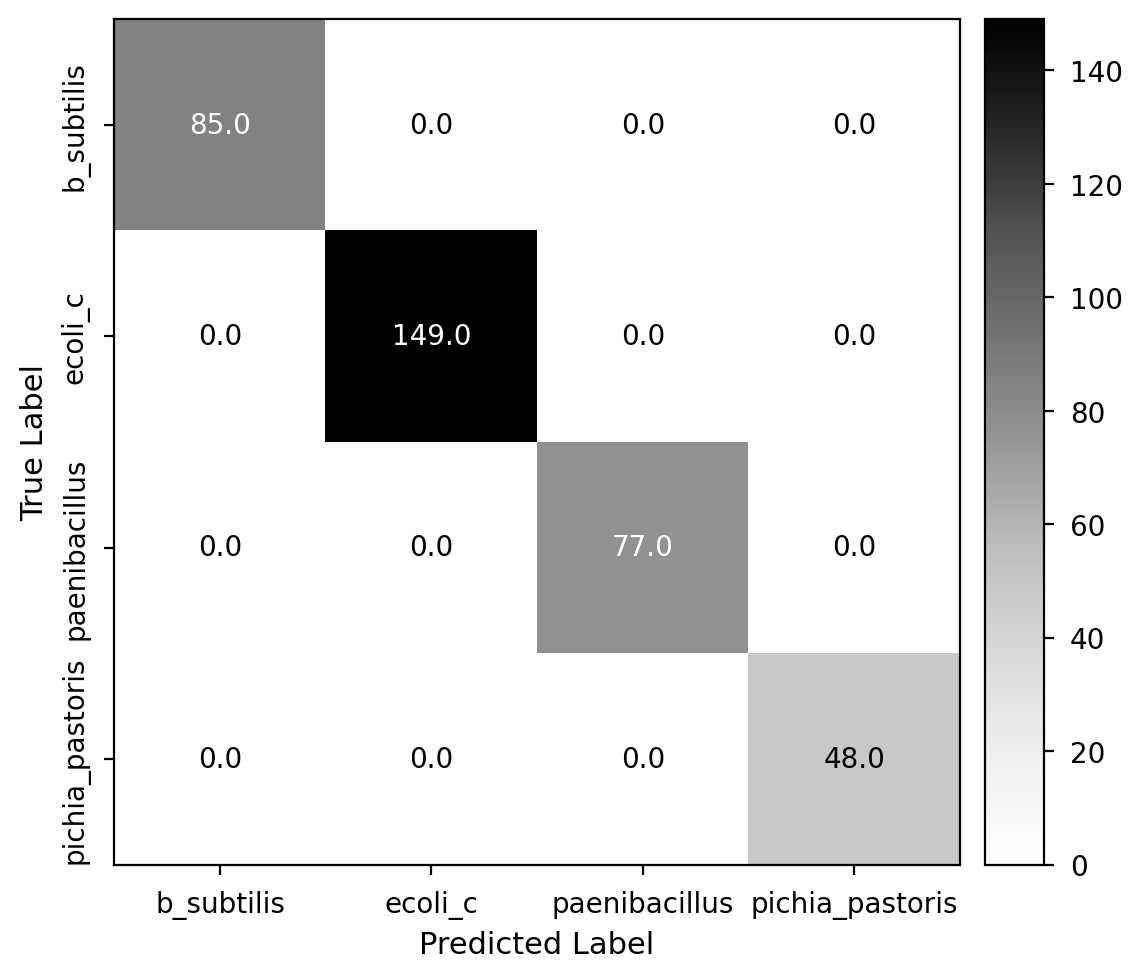

In [19]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

In [ ]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## NMF-LDA
### Overview

In [ ]:
current_path = results_path / "lda_dim_reduction/nmf_lda/"
name = "NMF-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

### Validation Curve

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Number of Components")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["Number of Components"])
ax.grid(axis="y")

### Confidence scores by class

In [ ]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 0.1, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

In [ ]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Feature Agglomeration (FA) - LDA
### Overview

In [ ]:
current_path = results_path / "lda_dim_reduction/fa_lda/"
name = "FA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

### Validation Curve

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["Number of Clusters"])
ax.grid(axis="y")

### Confidence scores by class

In [ ]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 0.1, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

In [ ]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Peak-LDA
### Overview

In [ ]:
current_path = results_path / "lda_dim_reduction/peak_lda/"
name = "Peak-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

### Validation Curve

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Min. Distance between Peaks")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["Min. Distance between Peaks"])
ax.grid(axis="y")

### Confidence scores by class

In [ ]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 3, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

In [ ]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Comparison of LDA with different dimensionality Reductions

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(accs, regex="LDA")

ax.grid(axis="y")
ax.set_ylabel("Accuracy")

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(p_vals, regex="LDA")

ax.set_yscale("log")
ax.grid(axis="y")
ax.set_ylabel("p-Value")

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(fit_times, regex="LDA")

ax.grid(axis="y")
ax.set_ylabel("Fit Time (s)")

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(predict_times, regex="LDA")

ax.grid(axis="y")
ax.set_ylabel("Predict Time (s)")

In [ ]:
fig, ax = plt.subplots()
plot_roc_comparison(rocs, aucs, ax=ax, regex="LDA")

ax.grid()
ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")

# Regularized Models
## Logistic Regression (l1)
### Overview

In [ ]:
current_path = results_path / "regularized_models/logreg_l1/"
name = "Log. Reg. (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

### Validation Curve

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xscale("log")
ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["C"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

In [ ]:
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(proba_df, y_key[y], y_key, ax=ax)
ax.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_yscale("logit")
ax.set_ylabel("Probability (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 0.05, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

In [ ]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(proba_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Logistic Regression (l2)
### Overview

In [ ]:
current_path = results_path / "regularized_models/logreg_l2/"
name = "Log. Reg. (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

### Validation Curve

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xscale("log")
ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["C"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

In [ ]:
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(proba_df, y_key[y], y_key, ax=ax)
ax.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_yscale("logit")
ax.set_ylabel("Probability (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True)

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

In [ ]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(proba_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Support Vector Machine (l1)
### Overview

In [ ]:
current_path = results_path / "regularized_models/svm_l1/"
name = "SVM (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

### Validation Curve

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xscale("log")
ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["C"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

In [ ]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 0.03, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

In [ ]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Support Vector Machine (l2)
### Overview

In [ ]:
current_path = results_path / "regularized_models/svm_l2/"
name = "SVM (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

### Validation Curve

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xscale("log")
ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["C"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

In [ ]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence Score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True)

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

In [ ]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Comparison of Regularized Models (Logistic Regression and Linear SVM)

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(accs, regex="Log. Reg.|SVM")

ax.grid(axis="y")
ax.set_ylabel("Accuracy")

fig.savefig(img_path / "linear_accuracy.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(p_vals, regex="Log. Reg.|SVM")

ax.set_yscale("log")
ax.grid(axis="y")
ax.set_ylabel("p-Value")

fig.savefig(img_path / "linear_pval.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(fit_times, regex="Log. Reg.|SVM")

ax.grid(axis="y")
ax.set_ylabel("Fit Time (s)")

fig.savefig(img_path / "linear_fittime.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
boxplot_comparison(predict_times, regex="Log. Reg.|SVM")

ax.grid(axis="y")
ax.set_ylabel("Predict Time (s)")

fig.savefig(img_path / "linear_predicttime.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots()
plot_roc_comparison(rocs, aucs, ax=ax, regex="Log. Reg.|SVM")

ax.grid()
ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")

fig.savefig(img_path / "linear_roc.png", format="png", bbox_inches="tight")

## Decision Tree
### Overview

In [ ]:
current_path = results_path / "tree_based_models/decision_tree/"
name = "Decision Tree"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

### Validation Curve

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xscale("log")
ax.set_xlabel(r"$\alpha$ (Pruning)")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels([r"$\alpha$ (Pruning)"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

In [ ]:
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(proba_df, y_key[y], y_key, ax=ax)
ax.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_yscale("logit")
ax.set_ylabel("Probability (-)")
ax.grid(axis="y")

### Tree

In [ ]:
tree = graphviz.Source.from_file(current_path / "tree.dot")
tree.render(img_path / "tree", format="png")
tree

### Confusion Matrix

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

In [ ]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(proba_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

## Random Forest
### Overview

In [ ]:
current_path = results_path / "tree_based_models/random_forest/"
name = "Random Forest"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

### Validation Curve

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Feature Subsample")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["Feature Subsample"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

In [ ]:
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(proba_df, y_key[y], y_key, ax=ax)
ax.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_yscale("logit")
ax.set_ylabel("Probability (-)")
ax.grid(axis="y")

### Confusion Matrix

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

In [ ]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(proba_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

### Explainable AI - SHAP

In [ ]:
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/data.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)

In [ ]:
fig, ax = plt.subplots()
first_expl = explanation[0]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

fig.savefig(img_path / "randomforest_shap_waterfall.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(8, 12))
shap.summary_plot(explanation, feature_names=shap_features)

fig.savefig(img_path / "randomforest_shap.png", format="png", bbox_inches="tight")

In [ ]:
shap_val_df = pd.Series(data=np.mean(np.absolute(shap_vals), axis=0), index=shap_features)

fig, ax = plt.subplots()
plot_coefs(shap_val_df, ax=ax, col=False, annotate=True, annot_kw={"min_height": 0.25, 
                                                        "min_dist": 50,
                                                        "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Mean absolute SHAP value")
ax.margins(x=0, y=0.15)
ax.set_ylim(0, None)
ax.grid()

## Gradient Boosted Trees
### Overview

In [ ]:
current_path = results_path / "tree_based_models/gbdt/"
name = "Gradient-boosting"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

### Validation Curve

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Learning Rate")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax.set_xticklabels(["Learning Rate"])
ax.ticklabel_format(axis="y", style="scientific", scilimits=(-2, 2))
ax.grid(axis="y")

### Confidence scores by class

In [ ]:
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(proba_df, y_key[y], y_key, ax=ax)
ax.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_yscale("logit")
ax.set_ylabel("Probability (-)")
ax.grid(axis="y")

### Confusion Matrix

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

In [ ]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(proba_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

### Explainable AI - SHAP

In [ ]:
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/data.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)

In [ ]:
fig, ax = plt.subplots()
first_expl = explanation[0]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

fig.savefig(img_path / "gbdt_shap_waterfall.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(8, 12))
shap.summary_plot(explanation, feature_names=shap_features)

fig.savefig(img_path / "gbdt_shap.png", format="png", bbox_inches="tight")

In [ ]:
shap_val_df = pd.Series(data=np.mean(np.absolute(shap_vals), axis=0), index=shap_features)

fig, ax = plt.subplots()
plot_coefs(shap_val_df, ax=ax, col=False, annotate=True, annot_kw={"min_height": 0.05, 
                                                                   "min_dist": 50,
                                                                   "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Mean absolute SHAP value")
ax.margins(x=0, y=0.15)
ax.set_ylim(0, None)
ax.grid()

## Comparison of Tree-based Models

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
boxplot_comparison(accs, regex="Tree|Forest|Gradient")

ax.grid(axis="y")
ax.set_ylabel("Accuracy")

fig.savefig(img_path / "tree_accuracy.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
boxplot_comparison(p_vals, regex="Tree|Forest|Gradient")

ax.set_yscale("log")
ax.grid(axis="y")
ax.set_ylabel("p-Value")

fig.savefig(img_path / "tree_pval.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
boxplot_comparison(fit_times, regex="Tree|Forest|Gradient")

ax.grid(axis="y")
ax.set_ylabel("Fit Time (s)")

fig.savefig(img_path / "tree_fittime.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
boxplot_comparison(predict_times, regex="Tree|Forest|Gradient")

ax.grid(axis="y")
ax.set_ylabel("Predict Time (s)")

fig.savefig(img_path / "tree_predicttime.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots()
plot_roc_comparison(rocs, aucs, ax=ax, regex="Tree|Forest|Gradient")

ax.grid()
ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")

fig.savefig(img_path / "tree_roc.png", format="png", bbox_inches="tight")

## Overall Comparison

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
boxplot_comparison(accs, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")

ax.grid(axis="y")
ax.set_ylabel("Accuracy")

fig.savefig(img_path / "all_accuracy.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
boxplot_comparison(p_vals, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")

ax.set_yscale("log")
ax.grid(axis="y")
ax.set_ylabel("p-Value")

fig.savefig(img_path / "all_pval.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
boxplot_comparison(fit_times, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")

ax.grid(axis="y")
ax.set_ylabel("Fit Time (s)")

fig.savefig(img_path / "all_fittime.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
boxplot_comparison(predict_times, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")

ax.grid(axis="y")
ax.set_ylabel("Predict Time (s)")

fig.savefig(img_path / "all_predicttime.png", format="png", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots()
plot_roc_comparison(rocs, aucs, ax=ax, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")

ax.grid()
ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")

fig.savefig(img_path / "all_roc.png", format="png", bbox_inches="tight")